In [63]:
import re
import random
import pandas as pd
import hashlib

In [64]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [65]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,148.164556,16.462728,26.110153,9
Email Auth and Security,240.339141,60.084785,82.114387,4
"Jane Eyre, Bronte",489.418162,61.177270,93.906532,8
RAG Project,501.949983,83.658331,132.530648,6
Azure VM + Developer,725.717447,21.344631,32.426471,34
Azure AD Authentication,927.966677,77.330556,158.165549,12
TSQL,946.893967,39.453915,54.473174,24
Logging in Python,1112.650412,79.475029,122.519260,14
Terraform,1637.676765,90.982043,154.783537,18
Azure Private DNS,1692.172358,89.061703,166.566381,19


# Histogram

sum of ages: ~52534.26


<Axes: >

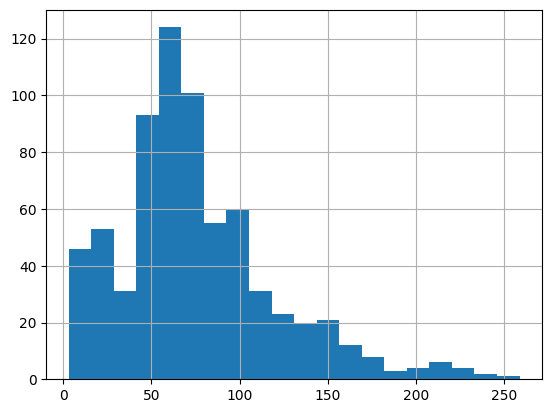

In [66]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52534.26


<Axes: >

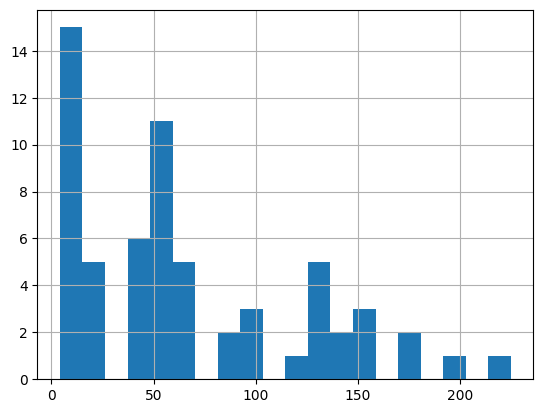

In [67]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [68]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [69]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [70]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [71]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [72]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [73]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [74]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [75]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 698
Total card age: 52534.26


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
170,Vocab,"Well of Lost Plots, Fforde\nJetty\nnoun | JET-...",8dba0eeb2b126c34332d0e08b7c65d66,-151.784232,63.499327,151.784232,-4254.454927,0.97625,0,0
171,Vocab,"Red Side Story, FForde\nProscenium\nPronunciat...",0a777acbd31f5de1da6c3418625c21b6,-89.797223,63.499327,151.784232,-4254.454927,0.97625,3,0
172,Vocab,Lost in a Good Book\nLerwick: The main town an...,90161cb4932f336d65897d5b2c2ca180,-81.875089,63.499327,151.784232,-4254.454927,0.97625,6,0
412,Vocab,"Jingo, Pratchett\nDekko\nnoun | DEK-oh\nA quic...",5921aff744e2a2baf8d8d09bca0612f3,-78.344904,63.499327,151.784232,-4254.454927,0.97625,9,0
640,Vocab,"Something Rotten, Fforde\nCoriolanus\nnoun | k...",36d5828bbf54955119829d60eaf66e9b,-76.262985,63.499327,151.784232,-4254.454927,0.97625,12,0
175,Vocab,"Something Rotten, Fforde\nBrocade (dress)\nnou...",5779ed3ba5605d0786578fbf87d737bd,-74.371593,63.499327,151.784232,-4254.454927,0.97625,15,0
176,Vocab,"Something Rotten, Fforde\nFlorin\nnoun | FLOR-...",ec6577b2a2dbbd383fecbf30faf61157,-69.687856,63.499327,151.784232,-4254.454927,0.97625,18,0
643,Vocab,"Well of Lost Plots, Fforde\nFoolscap\nnoun | F...",7bc3a1b3cf6c60a4a387d6fb342d8781,-69.035332,63.499327,151.784232,-4254.454927,0.97625,21,0
178,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-68.130398,63.499327,151.784232,-4254.454927,0.97625,24,0
416,Vocab,"Jingo, Pratchett\nRotas\nnoun (plural) | ROH-t...",2962ebeb526e550908aa4da49c684448,-65.297682,63.499327,151.784232,-4254.454927,0.97625,27,0


## Age Mean

In [76]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [77]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [78]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [79]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [80]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
203,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,-3.128328,73.493129,123.437044,-2278.287010,0.937464,30,0
86,Azure Developer Associate,Configuration data stored in an App Configurat...,22293608d8680b7f657f335dbf029202,-4.140361,67.707839,224.715455,-4197.886017,0.526084,61,1
328,Azure Developer Associate,App Configuration doesn't version key values a...,c5b1da2f26c3dc2ad56cbaba6c51b9ed,-4.391445,67.707839,224.715455,-4197.886017,0.526084,60,0
557,Azure Developer Associate,For the .NET SDK for Azure Cosmos DB for NoSQL...,e2ff6f3c584a2c6c5faf78dcae2eb263,-4.434251,67.707839,224.715455,-4197.886017,0.526084,59,2
556,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,f5da4a10007b58ba8af2aaafb7b97a48,-6.289795,67.707839,224.715455,-4197.886017,0.526084,58,1
84,Azure Developer Associate,"In Azure App Configuration,\nFeature manager: ...",c901a14baf95edb2e2619bb15f279978,-6.976970,67.707839,224.715455,-4197.886017,0.526084,57,0
327,Azure Developer Associate,Azure App Configuration encrypts sensitive inf...,fc0360a578522e808e4d680619664a40,-7.518611,67.707839,224.715455,-4197.886017,0.526084,56,2
555,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,6b266a08728213cd70fbb1cf8e56b84d,-8.620744,67.707839,224.715455,-4197.886017,0.526084,55,1
85,Azure Developer Associate,"In Azure App Configuration,\nFeature flag: A f...",8bcb1de29c054bd4964e31961734bbbd,-8.742944,67.707839,224.715455,-4197.886017,0.526084,54,0
593,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,-9.428052,51.716439,171.336510,-3878.732916,0.263822,74,2


In [81]:
existing_cards.head(10).sum()

head                   VocabVocabVocabVocabVocabVocabVocabVocabVocabV...
body                   Well of Lost Plots, Fforde\nJetty\nnoun | JET-...
hash                   8dba0eeb2b126c34332d0e08b7c65d660a777acbd31f5d...
age                                                          -824.587294
subject_mean_age                                              634.993273
subject_highest_age                                          1517.842318
subject_age_sum                                            -42544.549267
head_random_roll                                                  9.7625
count                                                                135
n_fold                                                                 0
dtype: object

In [82]:
existing_cards['age'].mean()

-75.26398582747197